In [1]:
import GPy
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
import os
os.chdir('/home/saumya/Documents/Flame_dianostics-temperature_profile_estimation_using_ML/sample code/')

In [7]:
# load training data
absorb = scio.loadmat('absorbance_TX_hitemp.mat')['absorb']
paraMat = scio.loadmat('para_TX_hitemp.mat')
Temper = paraMat['Temper']
Temper=np.reshape(Temper,-1)[:,None]
Conc_1 = paraMat['Conc_1']
Conc_1=np.reshape(Conc_1,-1)[:,None]
Conc_2 = paraMat['Conc_2']
Conc_2=np.reshape(Conc_2,-1)[:,None]

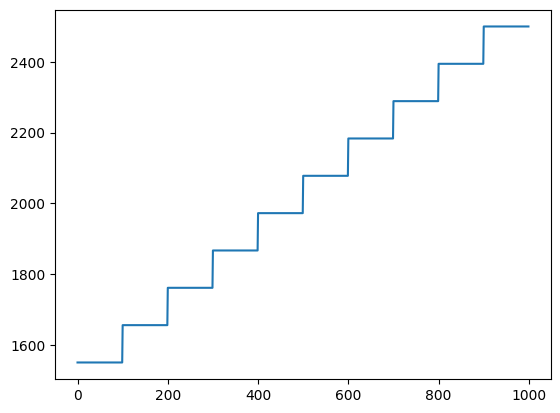

In [15]:
plt.plot(Temper)

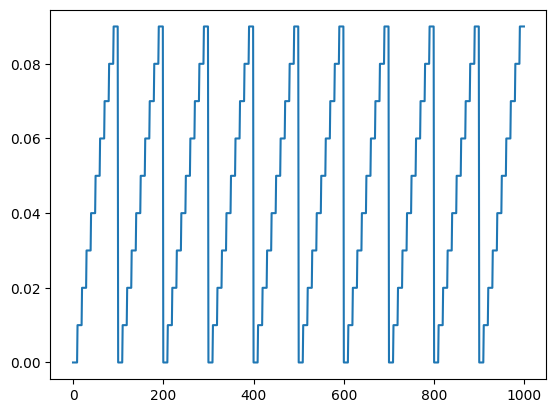

In [16]:
plt.plot(Conc_1)

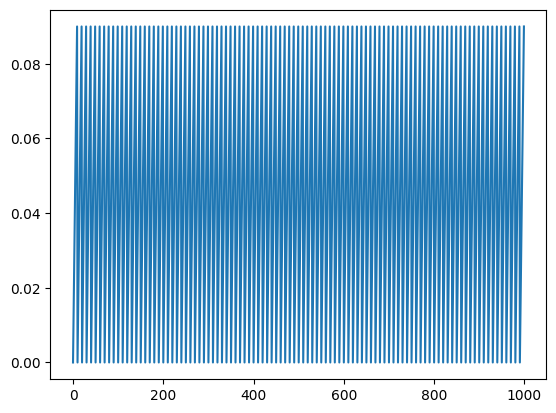

In [17]:
plt.plot(Conc_2)

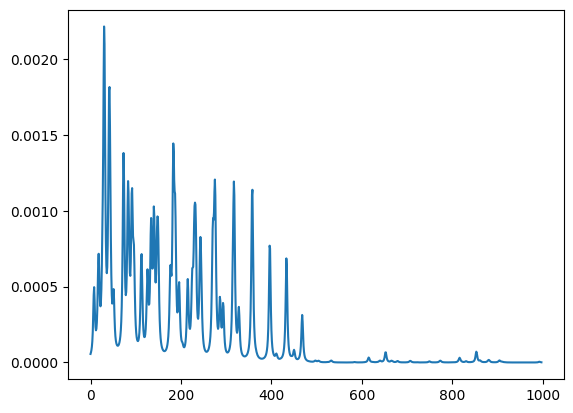

In [11]:
import matplotlib.pyplot as plt

plt.plot(absorb[1])

In [19]:
# normalization
scalerT = StandardScaler().fit(Temper)
scalerX_1 = StandardScaler().fit(Conc_1)
scalerX_2 = StandardScaler().fit(Conc_2)
Temper=scalerT.transform(Temper)
Conc_1=scalerX_1.transform(Conc_1)
Conc_2=scalerX_2.transform(Conc_2)

In [20]:
# ICM model set up
ks = GPy.kern.RBF(np.shape(absorb)[1])
icm = GPy.util.multioutput.ICM(input_dim=np.shape(absorb)[1],num_outputs=3,kernel=ks)

In [22]:
print(icm)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (3, 1)  |               |        
  B.kappa          |    (3,)  |      +ve      |        
W matrix
   index  |      ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.27275685  |               |        
  [1 0]  |   0.21918173  |               |        
  [2 0]  |  -0.51282086  |               |        

kappa vector
   index  |  ICM.B.kappa  |  constraints  |  priors
  [0]    |   0.50000000  |      +ve      |        
  [1]    |   0.50000000  |      +ve      |        
  [2]    |   0.50000000  |      +ve      |        

B matrix
 [[ 0.5743963  -0.05978332  0.1398754 ]
 [-0.05978332  0.54804063 -0.11240096]
 [ 0.1398754  -0.11240096  0.76298523]]


In [23]:
m = GPy.models.GPCoregionalizedRegression([absorb,absorb,absorb],[Temper,Conc_1,Conc_2],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)


Name : gp
Objective : 3721.0943255830894
Number of Parameters : 11
Number of Optimization Parameters : 10
Updates : True
Parameters:
  gp.                                    |   value  |  constraints  |  priors
  ICM.rbf.variance                       |     1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |     1.0  |      +ve      |        
  ICM.B.W                                |  (3, 1)  |               |        
  ICM.B.kappa                            |    (3,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |     1.0  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |     1.0  |      +ve      |        
  mixed_noise.Gaussian_noise_2.variance  |     1.0  |      +ve      |        


In [24]:
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)

W matrix
   index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.27275685  |               |        
  [1 0]  |   0.21918173  |               |        
  [2 0]  |  -0.51282086  |               |        

kappa vector
   index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        
  [1]    |      0.50000000  |      +ve      |        
  [2]    |      0.50000000  |      +ve      |        


In [25]:
m.optimize()

In [ ]:
print(m)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)

In [ ]:
# load test data and normalization
absorb_test = scio.loadmat('absorbance_TXtest_hitemp_noise.mat')['absorb']
paraMat_test = scio.loadmat('para_TXtest_hitemp.mat')
Temper_test = paraMat_test['Temper']
Temper_test=np.reshape(Temper_test,-1)[:,None]
Conc_1_test = paraMat_test['Conc_1']
Conc_1_test=np.reshape(Conc_1_test,-1)[:,None]
Conc_2_test = paraMat_test['Conc_2']
Conc_2_test=np.reshape(Conc_2_test,-1)[:,None]

In [ ]:
# prediction of T
newX = absorb_test
newX = np.concatenate((newX,np.zeros((np.shape(absorb_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

Temper_test_=scalerT.inverse_transform(ys)

In [ ]:
# prediction of X1
newX = absorb_test
newX = np.concatenate((newX,np.ones((np.shape(absorb_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

Conc_1_test_=scalerX_1.inverse_transform(ys)

In [ ]:
# prediction of X2
newX = absorb_test
newX = np.concatenate((newX,2*np.ones((np.shape(absorb_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

Conc_2_test_=scalerX_2.inverse_transform(ys)